In [1]:
from coef_helper_functions import *
from auditory_feature_helpers import *
plt.style.use('mb')

/home/mboos/anaconda2/lib/python2.7/site-packages/matplotlib/style/core.py:201: UserWarning: In /home/mboos/.config/matplotlib/stylelib/mb.mplstyle: Bad val "white" on line #20
	"grid.linewidth: white
"
	in file "/home/mboos/.config/matplotlib/stylelib/mb.mplstyle"
	Key grid.linewidth: Could not convert "white" to float
  warnings.warn(message)
/home/mboos/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
auditory_feature_helpers.py:3: DeprecationWarning: Python2 support is deprecated and will be removed in a future release. Consider switching to Python3.
  from nilearn import image as img
/home/mboos/anaconda2/lib/python2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatib

# Load data

In [182]:
feature_dict = get_feature_dict()
bsc = feature_dict.pop('BSC')
estimator = get_average_estimator()
joint_pcs = estimator.predict(bsc)
ratings_dict = joblib.load('ratings_dict.pkl')
joint_scores = get_feature_scores(feature_dict, joint_pcs, ratings_dict['ratings_idx'], estimator=LinearRegression())
cluster_dict = get_cluster_infos()
cluster_idx = cluster_dict.pop('index')
cluster_means = cluster_dict.pop('means')
Ws = joblib.load('logBSC_H200_W.pkl')
mps = np.concatenate([compute_MPS_from_STFT(w)[None] for w in Ws], axis=0)
mps_times, mps_freqs = compute_mps_time_and_freq_labels()
normalized_mps = np.concatenate([((mps_i-mps_i.min())/(mps_i.max()-mps_i.min()))[None] for mps_i in mps], axis=0)
mean_mps_per_cluster = [mps[cluster_idx==i].mean(axis=0) for i in range(7)]
mean_W_per_cluster = [Ws[cluster_idx==i].mean(axis=0) for i in range(7)]
best_time, best_freq = zip(*[np.unravel_index(np.argmax(mps[i][:,221:]), (10,221)) for i in range(200)])

In [201]:
np.argsort(best_freq)[-50:]

array([ 78,  83, 169,  12, 159,  42, 101, 179,  34, 186, 153,  84, 134,
       103, 165,  91,  52, 115, 146, 191, 151, 106,  97,  67, 112,  74,
       121,  14,  26, 172,  21, 189, 177, 178,  64, 117, 124,  70,   3,
        94,  95, 122, 185, 142, 180, 160, 168,  54, 175, 120])

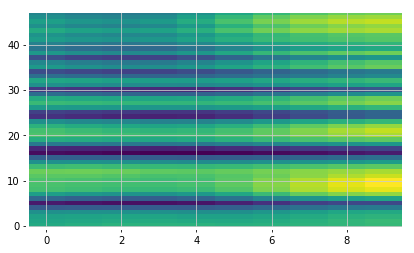

In [206]:
plt.imshow(Ws[180].T, origin='lower', aspect='auto')

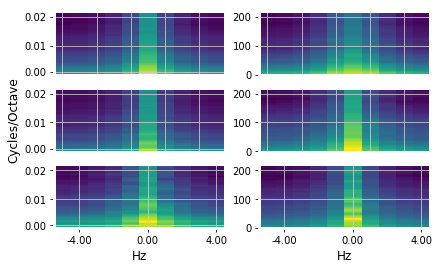

In [194]:
timemod_ticks = [1,5,9]
specmod_ticks = [10, 100, 200]

fig, axes = plt.subplots(3,2)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(np.log(mean_mps_per_cluster[i].T[221:]), origin='lower', aspect='auto')
    if i % 2 == 0:
        ax.set_yticks(specmod_ticks)
        ax.set_yticklabels(['{0:.2f}'.format(mps_freqs[221:][tm]) for tm in specmod_ticks])
        if i == 2:
            ax.set_ylabel('Cycles/Octave')
    else:
        ax.tick_params(which='both', axis='y', bottom=False, top=False, labelbottom=False)
    if i > 3:
        ax.set_xticks(timemod_ticks)
        ax.set_xticklabels(['{0:.2f}'.format(mps_times[tm]) for tm in timemod_ticks])
        ax.set_xlabel('Hz')
    else:
        ax.tick_params(which='both', axis='x', bottom=False, top=False, labelbottom=False)
fig.savefig('MPS_mean_cluster.svg')

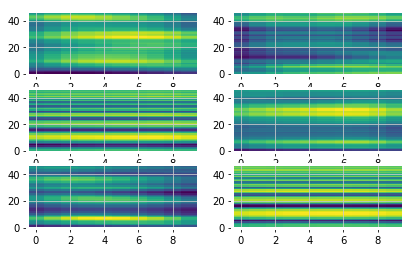

In [142]:
timemod_ticks = [1,5,9]
specmod_ticks = [10, 100, 200]

fig, axes = plt.subplots(3,2)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(mean_W_per_cluster[i].T, origin='lower', aspect='auto')

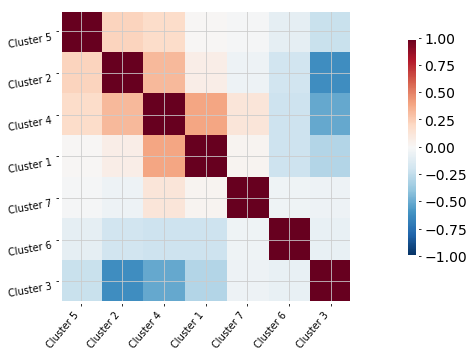

In [116]:
from nilearn.plotting import plot_matrix
labels = ['Cluster {}'.format(i) for i in range(1,8)]
plot_matrix(np.corrcoef(cluster_means,rowvar=1), labels=labels, vmin=-1,vmax=1, reorder=True)
#plt.savefig('Reordered_cluster_correlations.svg')

In [113]:
# df for plotting correlations with PCs
corr_df = get_corr_df(joint_pcs, cluster_means, cluster_idx)

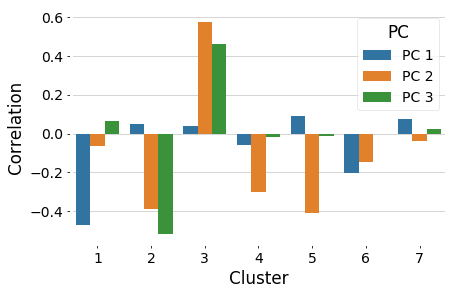

In [115]:
sns.barplot(data=corr_df, x='Cluster', y='Correlation', hue='PC')
plt.savefig('Cluster_pc_corrs_reordered.svg')

In [10]:
n_samples, bins = np.histogram(joint_pcs[:,0], bins=5)
idx = np.digitize(joint_pcs[:,0], bins)

In [8]:
np.histogram(joint_pcs[:,2], bins=5)

(array([ 186, 1264, 1507,  540,   42]),
 array([-2.3709909 , -1.29161176, -0.21223262,  0.86714651,  1.94652565,
         3.02590479]))

In [ ]:
ratings_cmap = sns.cubehelix_palette(5, start=.5, light=.7, rot=-.75)
fig, ax = plt.subplots(1,1, figsize=(12,7))
for lbl, c in zip([-10,-5,0,5,10], ratings_cmap):
#    sns.kdeplot(seps_stim['SNR {}db'.format(lbl)], label='{} db'.format(lbl), ax=ax)
#    sns.distplot(seps_stim_neg['{} db'.format(lbl)], label='{} db'.format(lbl), ax=ax, kde=False, hist_kws={'histtype' : 'step', 'alpha' : 0.8, 'color':c, 'linestyle' : 'dashed', 'linewidth':3})
    sns.distplot(seps_stim['SNR {} db'.format(lbl)], bins=20, label='SNR {} db'.format(lbl), ax=ax, kde=False, hist_kws={'histtype' : 'step', 'alpha' : 0.8, 'color':c, 'linestyle' : 'solid', 'linewidth':3})
plt.legend(loc=2)
plt.xlabel('Time-frequency separability')
plt.ylabel('Frequency')

In [ ]:
def make_barplot_df(dict_of_hists, edges):
    edge_names = np.array(['{} - {}'.format(edges[i], edges[i+1]) for i in range(len(edges)-1)])
    categories = np.concatenate([np.repeat(edge_names, dict_of_hists[label]) for label in [-10, -5, 0, 5, 10]])
    snr = np.repeat(np.array([-10,-5,0,5,10]), [dict_of_hists[label].sum() for label in [-10, -5, 0, 5, 10]])
    df = pd.DataFrame({'SNR' : snr, 'Separability range' : categories})
    return df    

In [ ]:
ratings_cmap = sns.cubehelix_palette(5, start=.5, light=.7, rot=-.75)
fig, ax = plt.subplots(1,1, figsize=(12,7))
edges = [0.,0.6,0.7,0.8,0.9,1.0]
hists = {lbl : np.histogram(seps_stim['SNR {} db'.format(lbl)], bins=edges)[0] for lbl in [-10,-5,0,5,10]}
df = make_barplot_df(hists, edges)
sns.countplot(x='Separability range', hue='SNR', data=df, palette=ratings_cmap)
plt.ylabel('Number of active basis functions')
plt.savefig('separability_range_barplot.svg')

In [3]:
ft_corrs = {ft_name : {cl : np.corrcoef(cluster_means[i], feature_dict[ft_name])[0,1] for i, cl in enumerate(np.unique(cluster_idx))}
            for ft_name in ['Sound level (db)', 'Time-Frequency Separability', 'Speech duration (s)']}
ft_corrs['Noise rating'] = {cl : np.corrcoef(cluster_means[i][ratings_dict['ratings_idx']],
                                             feature_dict['Noise rating'])[0,1] for i, cl in enumerate(np.unique(cluster_idx))}
cluster_corrs = {cl : {ft_name : ft_corrs[ft_name][cl] for ft_name in ['Sound level (db)', 'Time-Frequency Separability', 'Speech duration (s)', 'Noise rating']}
                 for cl in [0,1,2,5,6,8,9]}
ft_corr_df = pd.concat([pd.DataFrame(ft_corrs).melt(), pd.Series(np.tile(['1 (merged)', '2', '3', '6', '7', '9', '10'], 4))], axis=1, ignore_index=True)
ft_corr_df.columns = ['Auditory feature', 'Correlation', 'Cluster']

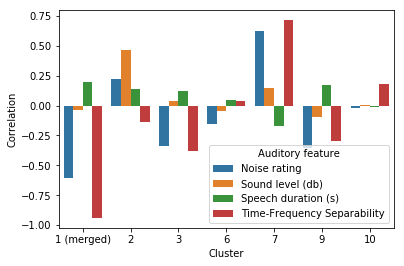

In [57]:
sns.barplot(data=ft_corr_df, x='Cluster', y='Correlation', hue='Auditory feature')
plt.savefig('Feature_cluster_corrs.svg')

In [39]:
coef_clusters = {cl : get_cluster_coefs_from_estimator(estimator.transformedcomp, cluster_idx==cl) for cl in np.unique(cluster_idx)}
df = pd.concat([pd.concat([make_df_for_lineplot(coef_clusters[cl]),pd.Series(['Cluster {}'.format(cl+1)]*coef_clusters[cl][:3].size, name='Cluster')], axis=1)
      for cl in coef_clusters])

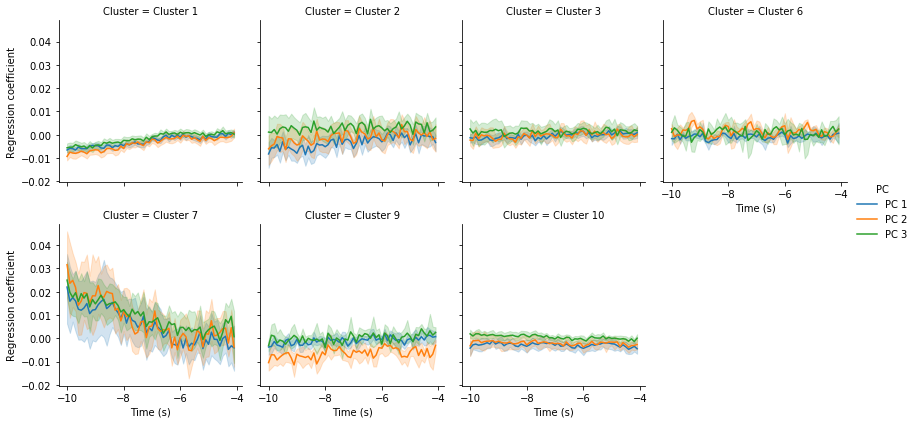

In [6]:
g = sns.FacetGrid(df, col='Cluster', col_order=df.Cluster.unique(), col_wrap=4, hue='PC', legend_out=True)
g = g.map(sns.lineplot, 'Time (s)', 'Regression coefficient', hue_order=['PC 1', 'PC 2', 'PC 3']).add_legend()
g.savefig('Coefficients_per_cluster_time.svg')

In [37]:
coef_clusters[0].shape

NameError: name 'coef_clusters' is not defined

In [26]:
test_coefs = np.reshape(coef_clusters[0][:3], (-1,99))
test_coefs2 = np.concatenate([test_coefs, np.reshape(coef_clusters[6][:3], (-1, 16))], axis=-1)

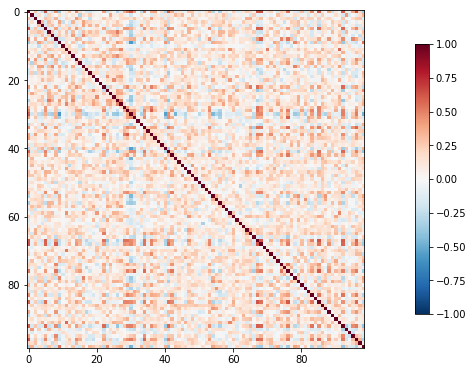

In [10]:
from nilearn.plotting import plot_matrix
plot_matrix(np.corrcoef(test_coefs, rowvar=0), vmax=1, vmin=-1)